In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
man_jan_df = pickle.load(open('./data/boroughs_df/manhattan_2020_01.pkl','rb'))
brook_jan_df = pickle.load(open('./data/boroughs_df/brooklyn_2020_01.pkl','rb'))
bronx_jan_df = pickle.load(open('./data/boroughs_df/bronx_2020_01.pkl','rb'))
staten_jan_df = pickle.load(open('./data/boroughs_df/staten_2020_01.pkl','rb'))
queens_jan_df = pickle.load(open('./data/boroughs_df/queens_2020_01.pkl','rb'))


We will be using datasets from different boroughs to do EDA and Modeling

## Import datasets

In [3]:
man_jan_df.head()

,pickup_time,PULocationID,fare_amount,tolls_amount,tip_amount,total_amount,trip_distance,Borough
17393,2020-01-01 00:00:00,48,6.5,0.0,0.00,10.30,1.43,Manhattan
17395,2020-01-01 00:00:00,48,8.5,0.0,0.00,12.30,1.35,Manhattan
8483,2020-01-01 00:00:00,68,10.5,0.0,2.85,17.15,2.20,Manhattan
53166,2020-01-01 00:00:00,68,5.5,0.0,0.00,9.30,0.96,Manhattan
44225,2020-01-01 00:00:00,144,18.5,0.0,0.00,22.30,5.44,Manhattan


In [4]:
brook_jan_df.head()

,pickup_time,PULocationID,fare_amount,tolls_amount,tip_amount,total_amount,trip_distance,Borough
1939,2020-01-01 00:01:59,181,4.5,0.0,0.00,5.80,0.70,Brooklyn
8537,2020-01-01 00:03:18,228,30.2,0.0,0.00,31.00,0.00,Brooklyn
1056,2020-01-01 00:03:22,190,27.0,0.0,0.00,28.30,7.48,Brooklyn
10034,2020-01-01 00:03:22,97,24.0,0.0,0.00,27.80,6.83,Brooklyn
8654,2020-01-01 00:04:26,76,7.5,0.0,1.76,12.51,1.57,Brooklyn


In [5]:
bronx_jan_df.head()

,pickup_time,PULocationID,fare_amount,tolls_amount,tip_amount,total_amount,trip_distance,Borough
6339783,2020-01-01 00:02:38,136,71.83,6.12,0.0,81.00,24.51,Bronx
6339789,2020-01-01 00:03:00,136,48.35,0.00,0.0,51.90,11.66,Bronx
6339779,2020-01-01 00:03:00,81,26.77,0.00,0.0,30.32,6.96,Bronx
9030,2020-01-01 00:03:56,169,6.00,0.00,0.0,7.30,1.38,Bronx
2719,2020-01-01 00:05:36,47,7.00,0.00,0.0,8.30,1.40,Bronx


In [6]:
# Clean Data for each borough: Brooklyn     
# add count column 
def resample_ts_df(df, borough, year, month):
    df['count'] = df['pickup_time'].map(lambda x:1)
    # convert to datetime object
    df['pickup_time'] = df['pickup_time'].map(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))
    df = df[['pickup_time', 'count']]

    # setting index
    df = df.set_index(pd.DatetimeIndex(df['pickup_time']), drop=True)

    # Resample by hourly
    df = df.resample('H').sum()

    print('data cleaning complete!')
    
    pickle.dump(df, open(f'./data/boroughs_df/{borough}_ts_{year}_{month}.pkl','wb'))
    print('dump done')
    return df

In [7]:
weather_df = pd.read_csv('./data/temp/2020_01_temp.csv')

def merge_weather_data(weather_df, df):
    weather_df = weather_df[9:].reset_index(drop=True)
    df['temperature'] = weather_df.rename(columns={'Basel': 'temperature'}).drop(columns=['location']).values
    df['temperature'] = df['temperature'].astype(float)
    return df

In [8]:
brook_ts_jan_df = resample_ts_df(brook_jan_df, 'brooklyn', '2020', '01')

data cleaning complete!
dump done


In [9]:
brook_ts_jan_df = pickle.load(open('./data/boroughs_df/brooklyn_ts_2020_01.pkl','rb'))
brook_ts_jan_df.head()

,count
pickup_time,
2020-01-01 00:00:00,254
2020-01-01 01:00:00,718
2020-01-01 02:00:00,765
2020-01-01 03:00:00,448
2020-01-01 04:00:00,282


In [10]:
brook_ts_jan_df = merge_weather_data(weather_df, brook_ts_jan_df)

In [11]:
brook_ts_jan_df

,count,temperature
pickup_time,,
2020-01-01 00:00:00,254,34.682953
2020-01-01 01:00:00,718,35.042950
2020-01-01 02:00:00,765,34.574950
2020-01-01 03:00:00,448,33.512950
2020-01-01 04:00:00,282,34.088950
...,...,...
2020-01-31 19:00:00,127,52.556953
2020-01-31 20:00:00,106,50.540955
2020-01-31 21:00:00,127,49.730950


## EDA

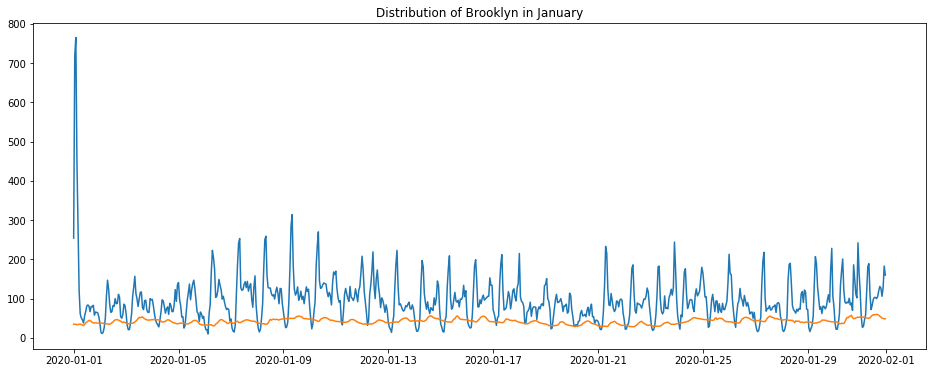

In [12]:
fig, ax=plt.subplots(figsize=(16,6))
plt.plot(brook_ts_jan_df, label='Brooklyn');
plt.title('Distribution of Brooklyn in January');

In [13]:
### ARIMA MODEL ####
from statsmodels.tsa.arima_model import ARIMA
#fit ARIMA model (3,1,0))
model = ARIMA(brook_ts_jan_df.iloc[:-1]['count'], order=(5,0,0)) 
arima_model_1 = model.fit(disp=0)
print(arima_model_1.summary())

                              ARMA Model Results                              
Dep. Variable:                  count   No. Observations:                  743
Model:                     ARMA(5, 0)   Log Likelihood               -3644.960
Method:                       css-mle   S.D. of innovations             32.643
Date:                Fri, 06 Nov 2020   AIC                           7303.920
Time:                        07:37:14   BIC                           7336.195
Sample:                    01-01-2020   HQIC                          7316.362
                         - 01-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          94.5401      2.940     32.157      0.000      88.778     100.302
ar.L1.count     1.1977      0.038     31.479      0.000       1.123       1.272
ar.L2.count    -0.5541      0.059     -9.361    

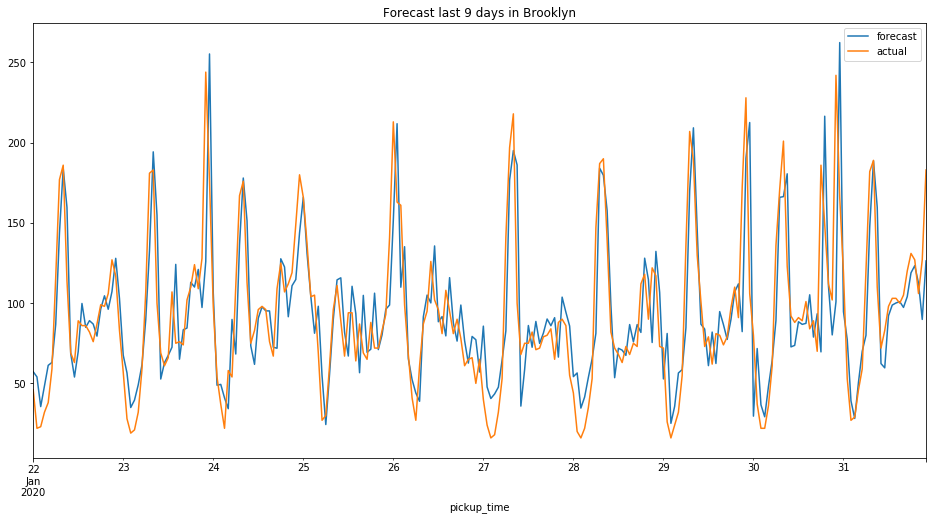

In [14]:
fig, ax=plt.subplots(figsize=(16,8))
arima_model_1.plot_predict( ax=ax, start="2020-01-22", end="2020-01-31 ");
plt.legend(['forecast', 'actual'])
plt.title('Forecast last 9 days in Brooklyn')
plt.show()

In [15]:
placeholder={}
arima_rmse_1= np.sqrt(np.mean(arima_model_1.resid**2))
print('Brooklyn RMSE for ARIMA #1:', arima_rmse_1)
placeholder['rmse_arima_1_brook'] = arima_rmse_1

Brooklyn RMSE for ARIMA #1: 34.67974599692669


## Queens

In [16]:
queens_jan_df.Borough.value_counts()

Queens    425421
Name: Borough, dtype: int64

In [17]:
queens_ts_jan_df = resample_ts_df(queens_jan_df, 'queens', '2020', '01')

data cleaning complete!
dump done


In [18]:
queens_ts_jan_df = merge_weather_data(weather_df, queens_ts_jan_df)

In [19]:
queens_ts_jan_df.head()

,count,temperature
pickup_time,,
2020-01-01 00:00:00,355,34.682953
2020-01-01 01:00:00,354,35.042950
2020-01-01 02:00:00,394,34.574950
2020-01-01 03:00:00,314,33.512950
2020-01-01 04:00:00,267,34.088950


### EDA

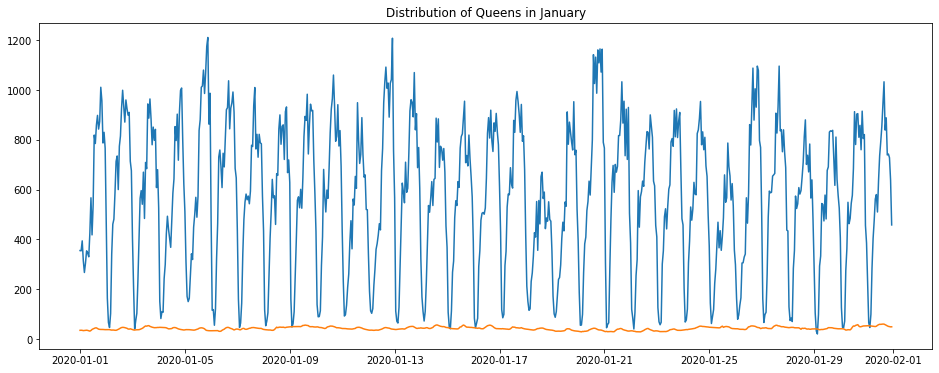

In [20]:
fig, ax=plt.subplots(figsize=(16,6))
plt.plot(queens_ts_jan_df, label='Brooklyn');
plt.title('Distribution of Queens in January');

In [21]:
### ARIMA MODEL ####
from statsmodels.tsa.arima_model import ARIMA
#fit ARIMA model (3,1,0))
model = ARIMA(queens_ts_jan_df.iloc[:-1]['count'], order=(3,0,1)) 
arima_queens_1 = model.fit(disp=0)
print(arima_queens_1.summary())

                              ARMA Model Results                              
Dep. Variable:                  count   No. Observations:                  743
Model:                     ARMA(3, 1)   Log Likelihood               -4576.404
Method:                       css-mle   S.D. of innovations            114.283
Date:                Fri, 06 Nov 2020   AIC                           9164.807
Time:                        07:37:49   BIC                           9192.472
Sample:                    01-01-2020   HQIC                          9175.472
                         - 01-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         571.5422      9.818     58.214      0.000     552.300     590.785
ar.L1.count     1.6637      0.046     35.976      0.000       1.573       1.754
ar.L2.count    -0.5799      0.080     -7.265    

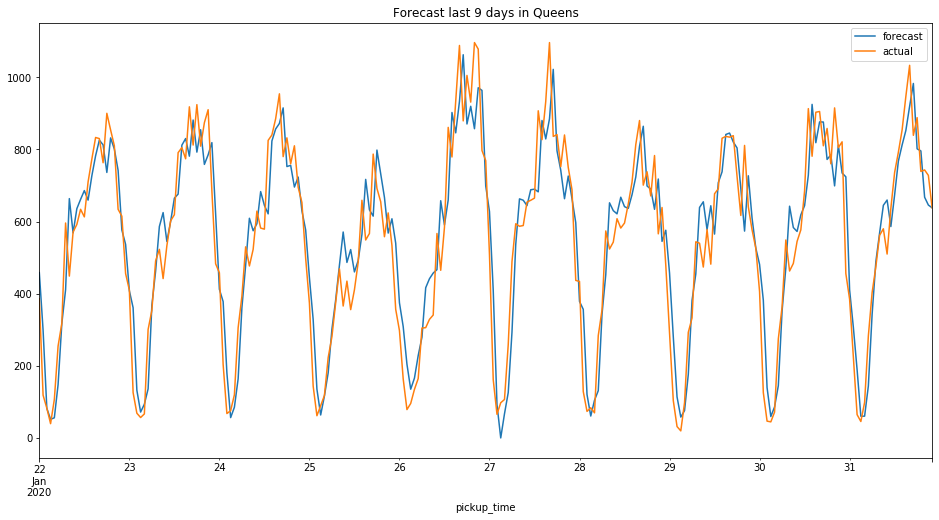

In [22]:
fig, ax=plt.subplots(figsize=(16,8))
arima_queens_1.plot_predict( ax=ax, start="2020-01-22", end="2020-01-31 ");
plt.legend(['forecast', 'actual'])
plt.title('Forecast last 9 days in Queens')
plt.show()

In [23]:
arima_rmse= np.sqrt(np.mean(arima_queens_1.resid**2))
print('Queens RMSE for ARIMA #1:', arima_rmse)
placeholder['rmse_arima_1_queens'] = arima_rmse

Queens RMSE for ARIMA #1: 114.53051245802749


## Manhattan

In [24]:
# man_ts_jan_df = resample_ts_df(man_jan_df, 'manhattan', '2020', '01')
man_ts_jan_df = pickle.load(open('./data/boroughs_df/manhattan_ts_2020_01.pkl','rb'))
man_ts_jan_df = merge_weather_data(weather_df, man_ts_jan_df)

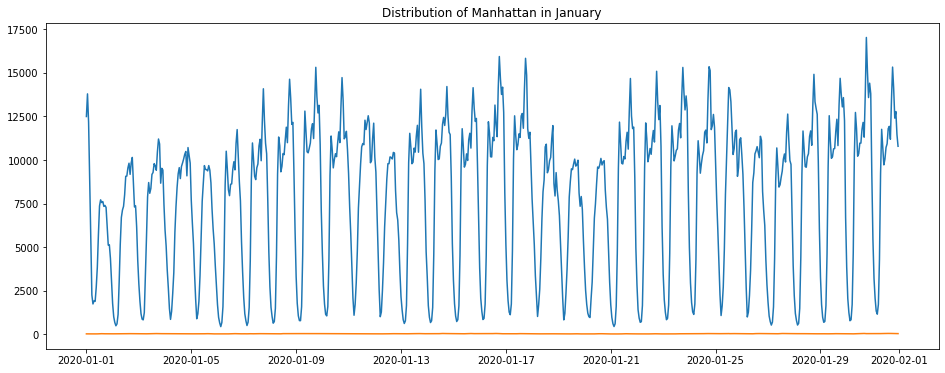

In [25]:
fig, ax=plt.subplots(figsize=(16,6))
plt.plot(man_ts_jan_df, label='Manhattan');
plt.title('Distribution of Manhattan in January');

In [26]:
man_ts_jan_df = merge_weather_data(weather_df, man_ts_jan_df)

In [27]:
man_ts_jan_df

,count,temperature
pickup_time,,
2020-01-01 00:00:00,12498,34.682953
2020-01-01 01:00:00,13796,35.042950
2020-01-01 02:00:00,12170,34.574950
2020-01-01 03:00:00,8920,33.512950
2020-01-01 04:00:00,5571,34.088950
...,...,...
2020-01-31 19:00:00,14099,52.556953
2020-01-31 20:00:00,12407,50.540955
2020-01-31 21:00:00,12781,49.730950


In [28]:
### ARIMA MODEL ####
from statsmodels.tsa.arima_model import ARIMA
#fit ARIMA model (3,1,0))
model = ARIMA(man_ts_jan_df.iloc[:-1]['count'], order=(4,0,0)) 
arima_man_1 = model.fit(disp=0)
print(arima_man_1.summary())

                              ARMA Model Results                              
Dep. Variable:                  count   No. Observations:                  743
Model:                     ARMA(4, 0)   Log Likelihood               -6253.825
Method:                       css-mle   S.D. of innovations           1091.634
Date:                Fri, 06 Nov 2020   AIC                          12519.650
Time:                        07:37:49   BIC                          12547.315
Sample:                    01-01-2020   HQIC                         12530.315
                         - 01-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7834.9602    258.152     30.350      0.000    7328.991    8340.930
ar.L1.count     1.6967      0.033     50.853      0.000       1.631       1.762
ar.L2.count    -1.2669      0.064    -19.820    

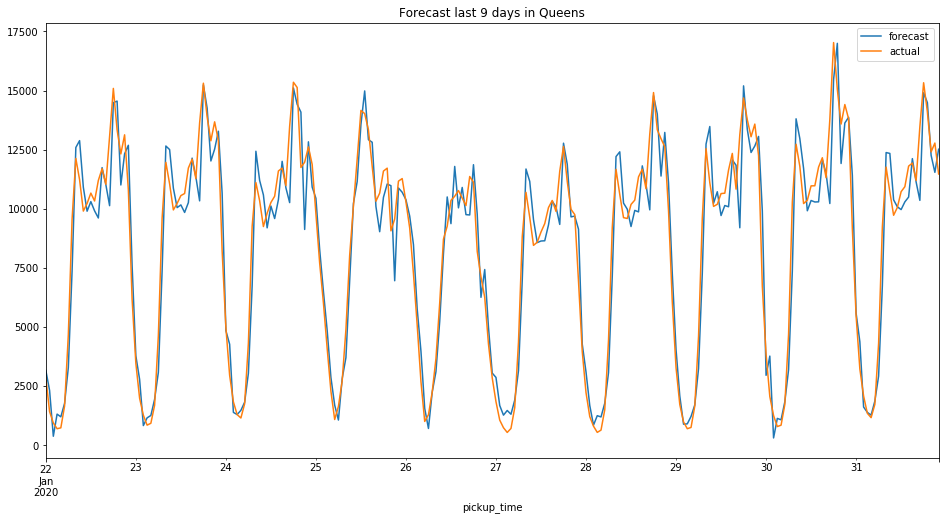

In [29]:
fig, ax=plt.subplots(figsize=(16,8))
arima_man_1.plot_predict( ax=ax, start="2020-01-22", end="2020-01-31 ");
plt.legend(['forecast', 'actual'])
plt.title('Forecast last 9 days in Queens')
plt.show()

In [30]:
arima_rmse= np.sqrt(np.mean(arima_man_1.resid**2))
print('Manhattan RMSE for ARIMA #1:', arima_rmse)
placeholder['rmse_arima_1_manhattan'] = arima_rmse

Manhattan RMSE for ARIMA #1: 1105.5301098543384


## Bronx

In [31]:
bronx_jan_df.Borough.value_counts()

Bronx    14072
Name: Borough, dtype: int64

In [32]:
bronx_ts_jan_df = resample_ts_df(bronx_jan_df, 'queens', '2020', '01')

data cleaning complete!
dump done


In [33]:
bronx_ts_jan_df = merge_weather_data(weather_df, bronx_ts_jan_df)

In [34]:
bronx_ts_jan_df.head()

,count,temperature
pickup_time,,
2020-01-01 00:00:00,45,34.682953
2020-01-01 01:00:00,60,35.042950
2020-01-01 02:00:00,64,34.574950
2020-01-01 03:00:00,49,33.512950
2020-01-01 04:00:00,24,34.088950


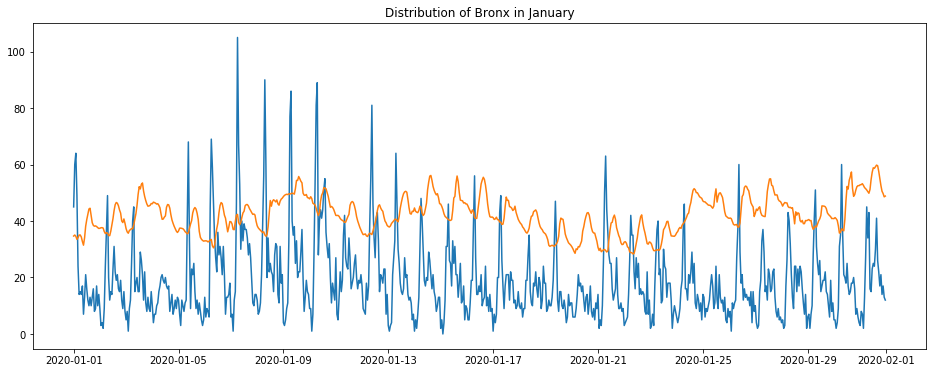

In [35]:
fig, ax=plt.subplots(figsize=(16,6))
plt.plot(bronx_ts_jan_df, label='Brooklyn');
plt.title('Distribution of Bronx in January');

In [36]:
### ARIMA MODEL ####
from statsmodels.tsa.arima_model import ARIMA
#fit ARIMA model (3,1,0))
model = ARIMA(bronx_ts_jan_df.iloc[:-1]['count'], order=(1,0,1)) 
arima_bronx_1 = model.fit(disp=0)
print(arima_queens_1.summary())

                              ARMA Model Results                              
Dep. Variable:                  count   No. Observations:                  743
Model:                     ARMA(3, 1)   Log Likelihood               -4576.404
Method:                       css-mle   S.D. of innovations            114.283
Date:                Fri, 06 Nov 2020   AIC                           9164.807
Time:                        07:37:51   BIC                           9192.472
Sample:                    01-01-2020   HQIC                          9175.472
                         - 01-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         571.5422      9.818     58.214      0.000     552.300     590.785
ar.L1.count     1.6637      0.046     35.976      0.000       1.573       1.754
ar.L2.count    -0.5799      0.080     -7.265    

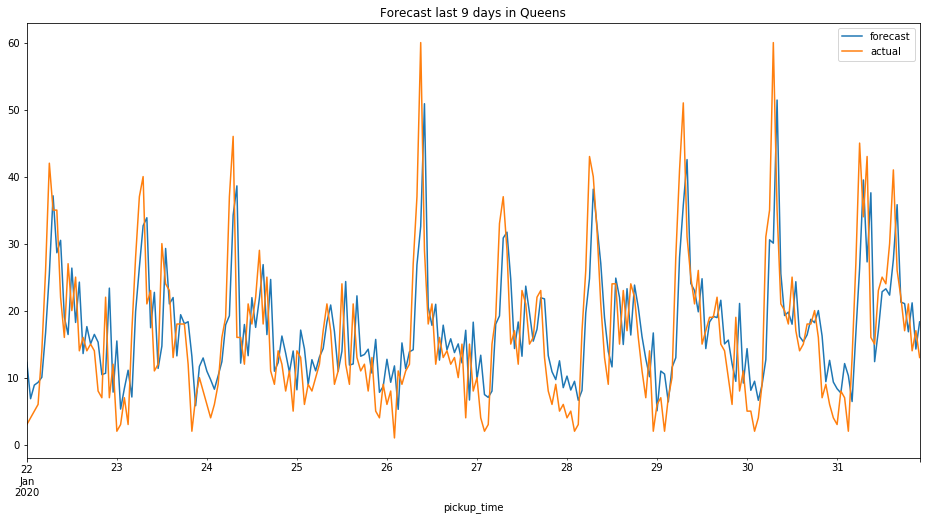

In [37]:
fig, ax=plt.subplots(figsize=(16,8))
arima_bronx_1.plot_predict( ax=ax, start="2020-01-22", end="2020-01-31 ");
plt.legend(['forecast', 'actual'])
plt.title('Forecast last 9 days in Queens')
plt.show()

In [38]:
arima_rmse= np.sqrt(np.mean(arima_bronx_1.resid**2))
print('Bronx RMSE for ARIMA #1:', arima_rmse)
placeholder['rmse_arima_1_bronx'] = arima_rmse

Bronx RMSE for ARIMA #1: 9.44280215262653


## Staten Island

In [39]:
staten_jan_df.head()

,pickup_time,PULocationID,fare_amount,tolls_amount,tip_amount,total_amount,trip_distance,Borough
6340013,2020-01-01 01:39:19,115,51.55,0.0,0.00,54.60,11.60,Staten Island
60306,2020-01-01 05:04:11,221,75.00,0.0,15.06,90.36,0.00,Staten Island
68356,2020-01-01 09:20:23,44,35.00,0.0,0.00,35.80,11.21,Staten Island
68719,2020-01-01 09:46:26,221,5.00,0.0,0.00,5.80,0.83,Staten Island
71937,2020-01-01 10:10:36,23,80.00,0.0,0.00,80.80,30.07,Staten Island


In [40]:
staten_ts_jan_df = resample_ts_df(bronx_jan_df, 'staten', '2020', '01')

data cleaning complete!
dump done


In [41]:
staten_ts_jan_df = merge_weather_data(weather_df, staten_ts_jan_df)

In [42]:
staten_ts_jan_df.head()

,count,temperature
pickup_time,,
2020-01-01 00:00:00,45,34.682953
2020-01-01 01:00:00,60,35.042950
2020-01-01 02:00:00,64,34.574950
2020-01-01 03:00:00,49,33.512950
2020-01-01 04:00:00,24,34.088950


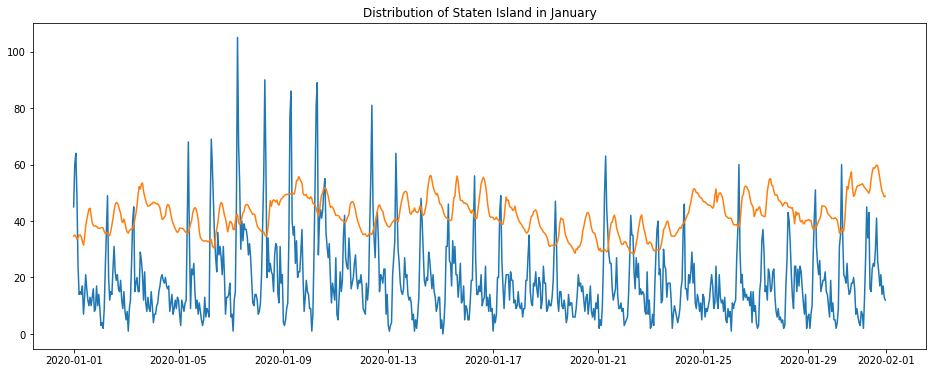

In [43]:
fig, ax=plt.subplots(figsize=(16,6))
plt.plot(staten_ts_jan_df, label='Staten Island');
plt.title('Distribution of Staten Island in January');

In [44]:
### ARIMA MODEL ####
from statsmodels.tsa.arima_model import ARIMA
#fit ARIMA model (3,1,0))
model = ARIMA(staten_ts_jan_df.iloc[:-1]['count'], order=(2,0,1)) 
arima_staten_1 = model.fit(disp=0)
print(arima_queens_1.summary())

                              ARMA Model Results                              
Dep. Variable:                  count   No. Observations:                  743
Model:                     ARMA(3, 1)   Log Likelihood               -4576.404
Method:                       css-mle   S.D. of innovations            114.283
Date:                Fri, 06 Nov 2020   AIC                           9164.807
Time:                        07:37:52   BIC                           9192.472
Sample:                    01-01-2020   HQIC                          9175.472
                         - 01-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         571.5422      9.818     58.214      0.000     552.300     590.785
ar.L1.count     1.6637      0.046     35.976      0.000       1.573       1.754
ar.L2.count    -0.5799      0.080     -7.265    

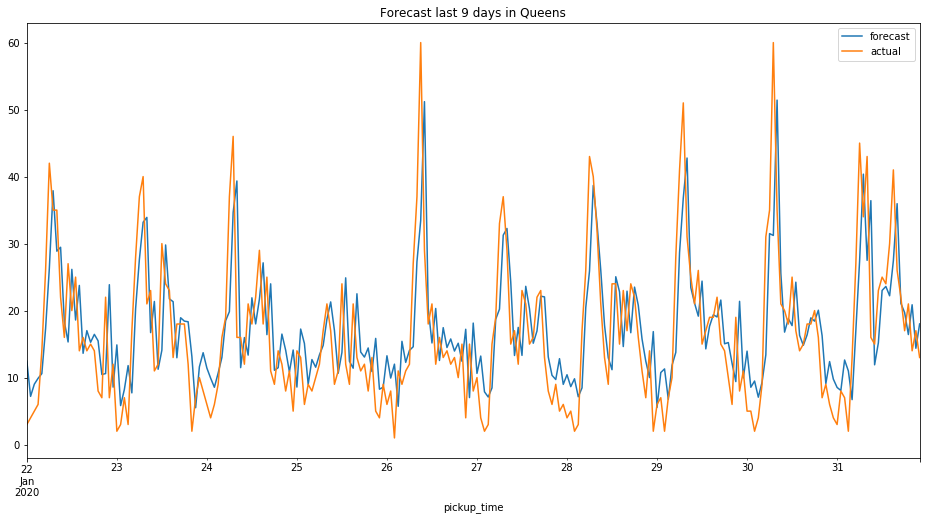

In [45]:
fig, ax=plt.subplots(figsize=(16,8))
arima_staten_1.plot_predict( ax=ax, start="2020-01-22", end="2020-01-31 ");
plt.legend(['forecast', 'actual'])
plt.title('Forecast last 9 days in Queens')
plt.show()

In [46]:
arima_rmse= np.sqrt(np.mean(arima_staten_1.resid**2))
print('Bronx RMSE for ARIMA #1:', arima_rmse)
placeholder['rmse_arima_1_staten'] = arima_rmse

Bronx RMSE for ARIMA #1: 9.4103447621591
